In [1]:
import numpy as np
import xspec

xspec.AllData.clear()
xspec.AllModels.clear()

xspec.Xset.restore("model.xcm")

xspec.Fit.statMethod = ("cstat")
xspec.Fit.bayes = "on"

xspec_observation = xspec.Spectrum(
    "spectrum_raw.pha"
)

low_energy, high_energy = 0.3, 12.
xspec_observation.ignore(f"0.0-{low_energy:.1f} {high_energy:.1f}-**")

xspec_model = xspec.AllModels(1)
xspec_model.show()

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Parameter delta values for fits will now be 0.01 * parValue

 The default systematic error for models is set to 0

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
Reading APEC data from 3.0.9


Model TBabs<1>*bapec<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Val

In [2]:
from bsixsa.convenience import set_prior_and_build_transform

define_prior = [
    ("bapec", "kT", 0.5, 3.5, "uniform"),
    ("bapec", "Abundanc", 0.5, 2.5, "uniform"),
    ("bapec", "Redshift", 0.2, 0.7, "uniform"),
    ("bapec", "Velocity", 50, 200, "uniform"),
    ("bapec", "norm", 0.5, 1.5, "loguniform")
]

transformations = set_prior_and_build_transform(xspec_model, define_prior)


Fit statistic  : C-Statistic                 6816.77     using 19094 bins.
   (Includes a Bayesian contribution of 1.39)

Test statistic : Chi-Squared                 5877.44     using 19094 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 19089 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                 6817.58     using 19094 bins.
   (Includes a Bayesian contribution of 2.20)

Test statistic : Chi-Squared                 5877.44     using 19094 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 19089 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                 6815.98     using 19094 bins.
   (Includes a Bayesian contribution of 0.60)

Test statistic : Chi-Squared               

In [3]:
from bsixsa import SIXSASolver

outputfiles_basename = "sixsa_result_mri_smork/"

solver = SIXSASolver(
    transformations,
    outputfiles_basename=outputfiles_basename,
    use_background=True
)

In [4]:
from bsixsa.scaterring_stuff import compress_with_wst_and_search_peaks, compress_with_wst

peaks_kwargs = dict(
    discard_prior_samples=True,
    force_first_round_loss=True,
    retrain_from_scratch=True,
    training_batch_size=256
)

vanilla_kwargs = dict(
    discard_prior_samples=False,
    force_first_round_loss=True,
    retrain_from_scratch=False,
    training_batch_size=256
)

posterior = solver.run(
    num_rounds=5,
    num_simulations=5000,
    training_kwargs=[vanilla_kwargs]+ [peaks_kwargs] + [vanilla_kwargs]*3,
    embedding=[compress_with_wst] + [compress_with_wst_and_search_peaks]*4
)

Round 1 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 79 epochs.

Round 2 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

Round 3 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs.

Round 4 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

Round 5 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Computing posterior statistic - Folding model:   0%|          | 0/1000 [00:00<?, ?it/s]

/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/priors.py:55: RuntimeWarning: overflow encountered in power
  def log_after_transform(x): return 10**x


   All chains are now removed.
  New chain sixsa_result_mri_smork/chain.fits is now loaded.
  Default chain length is now set to length of sixsa_result_mri_smork/chain.fits: 1000

Fit statistic  : C-Statistic                 6840.57     using 19094 bins.
   (Includes a Bayesian contribution of 9.72)

Test statistic : Chi-Squared                 5875.89     using 19094 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 19089 degrees of freedom
 Current data and model not fit yet.


  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


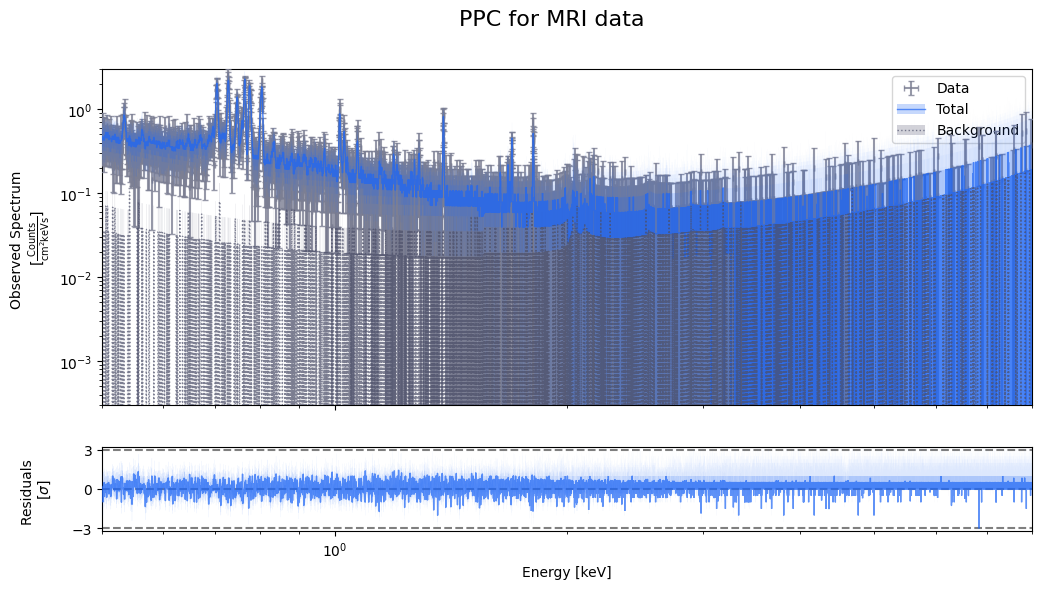

In [5]:
import importlib
import bsixsa
importlib.reload(bsixsa)
from bsixsa.plotting_stuff import plot_ppc
importlib.reload( bsixsa.plotting_stuff)
from bsixsa.plotting_stuff import plot_ppc
component_names = ["Total"]

fig = plot_ppc(solver, component_names=component_names, x_lim=(0.5, 8), y_lim=(3e-4, 3), plot_background=True)
fig.suptitle("PPC for MRI data", fontsize=16);

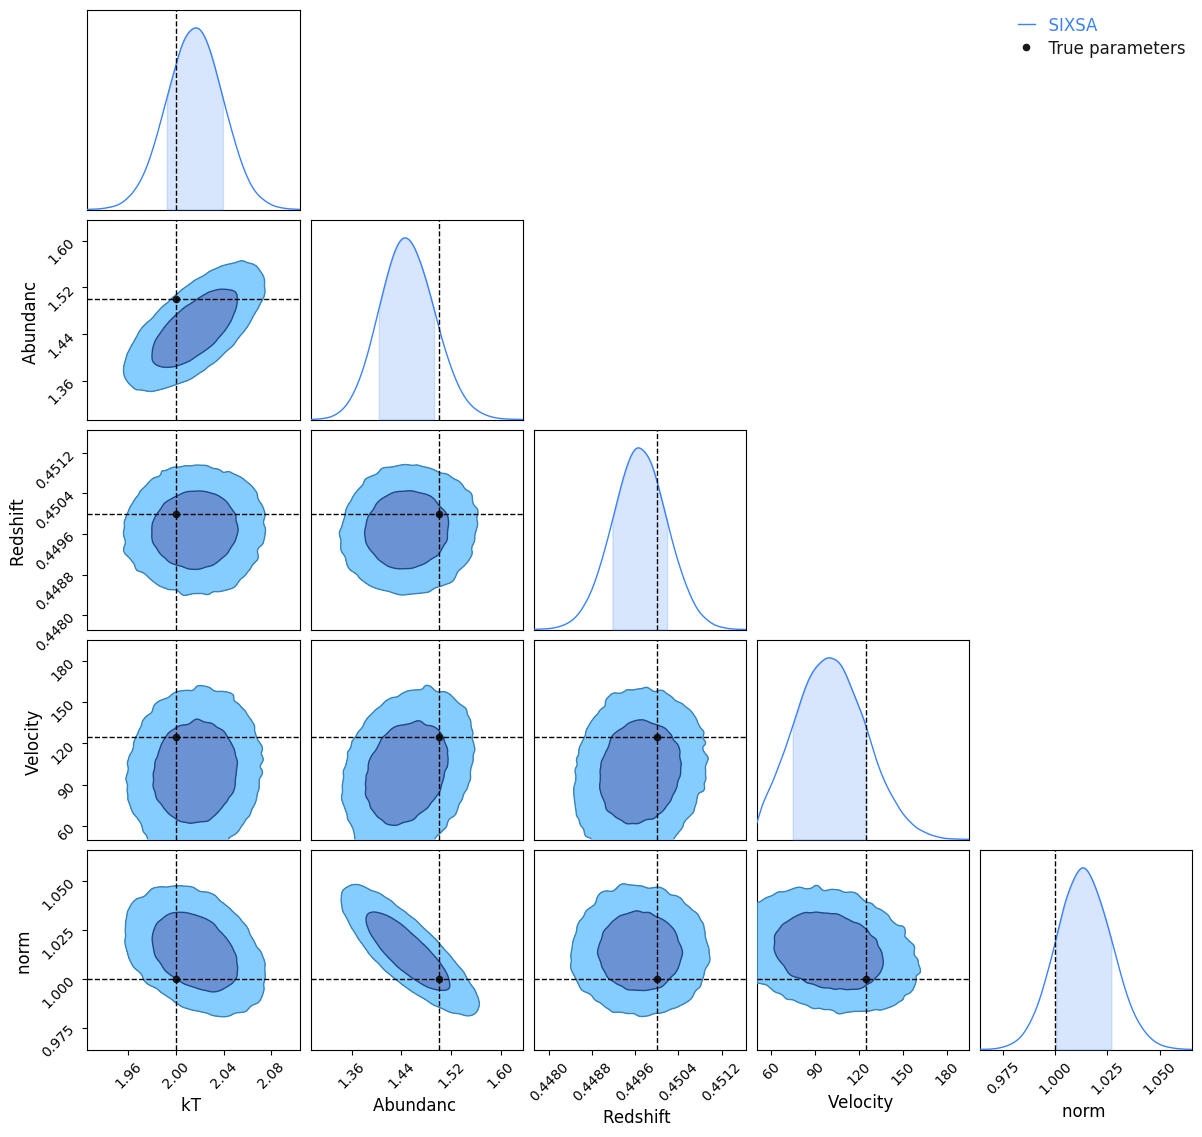

In [6]:
import pandas as pd
import numpy as np
from generate_ref_spectrum import truth

from chainconsumer import Chain, ChainConsumer, Truth

indexes = np.sort([t['index'] for t in solver.transformations])
parameter_names = np.asarray(solver.parameter_names_uniques)[indexes-1]

samples = posterior.sample((100000,))
warped_samples = solver.unit_cube_to_xspec(samples.numpy().T)

dict_of_params = {}

for i in indexes:
    name = solver.parameter_names_uniques[i-1]
    dict_of_params[name] = np.asarray([warped_samples[j][i] for j in range(len(warped_samples))])

cc = ChainConsumer()
chain = Chain(samples=pd.DataFrame.from_dict(dict_of_params), name="SIXSA")

truth = [truth[t["index"]] for t in solver.transformations]
truth_loc = {name:truth[i] for i, name in enumerate(parameter_names)}

cc.add_chain(chain)
#cc.add_chain(xspec_cov)
cc.add_truth(Truth(location=truth_loc, color="black"))
cc.add_marker(location=truth_loc, name="True parameters", color="black", marker_style="o", marker_size=20)
cc.plotter.plot();

In [7]:
pd.DataFrame.from_dict(dict_of_params).to_csv("../article/apec/results_df/sixsa_mri_summary.csv")

In [8]:
posterior_unit_cube = posterior.sample((10_000,)).numpy().T
posterior_bxa = solver.prior_function(posterior_unit_cube)
posterior_xspec = solver.unit_cube_to_xspec(posterior_unit_cube)
posterior_sims = solver.simulate(posterior_xspec, return_stat=False, desc="Computing posterior statistic - ")

Computing posterior statistic - Folding model:   0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
from bsixsa.scaterring_stuff import kymatio_compress_spectra_mps, select_j_q

def scattering_transform(data_transformed):

    if data_transformed.ndim == 1:
        data_transformed = data_transformed.reshape(1, -1)

    num_spectra, num_bins = data_transformed.shape
    J_opt, Q_opt = select_j_q(num_bins)

    return kymatio_compress_spectra_mps(
        data_transformed,
        max_orders=None,
        J=J_opt, Q=Q_opt,
    )

ImportError: cannot import name 'kymatio_compress_spectra_mps' from 'bsixsa.scaterring_stuff' (/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/scaterring_stuff.py)

In [10]:
res, _ = scattering_transform(posterior_sims)
res.shape

(10000, 3696)

In [11]:
posterior_bxa.T.shape

(10000, 5)

In [12]:
params = posterior_bxa
obs = res.T

In [13]:
import numpy as np

# Supposons que vous avez :
# params.shape = (5, 10000)
# obs.shape    = (1104, 10000)

# 1. On concatène verticalement les paramètres et les observables.
#    La matrice résultante aura pour forme (5 + 1104, 10000)
data = np.vstack((params, obs))

# 2. Calcul de la matrice de corrélation avec np.corrcoef.
#    La fonction calcule la corrélation entre chaque paire de lignes.
corr_matrix = np.corrcoef(data)

# 3. Extraction de la sous-matrice des corrélations entre les paramètres (lignes 0 à 4)
#    et les observables (lignes 5 à 1108)
corr_params_obs = corr_matrix[:5, 5:]

avg_abs_corr = np.abs(corr_params_obs).mean(axis=0)
indices_trie = np.argsort(avg_abs_corr)[::-1]
top_200_indices = indices_trie[:200]
obs_top200 = obs[top_200_indices, :]

print(corr_params_obs)  # Affiche la matrice de corrélation de forme (5, 1104)


[[ 0.07495847  0.08018603  0.08225891 ... -0.21157272 -0.21168267
  -0.21176444]
 [ 0.00519124  0.00866326  0.00986723 ...  0.10433263  0.1042462
   0.1041717 ]
 [ 0.00248686  0.00324229  0.00351316 ... -0.08167279 -0.08166111
  -0.08163918]
 [-0.01442895 -0.01404299 -0.01391754 ...  0.04496609  0.04495091
   0.0449353 ]
 [ 0.44279612  0.44120345  0.44069464 ... -0.07583582 -0.07578085
  -0.0757333 ]]


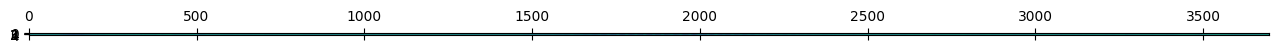

In [14]:
import matplotlib.pyplot as plt
plt.matshow(corr_params_obs)

<StemContainer object of 3 artists>

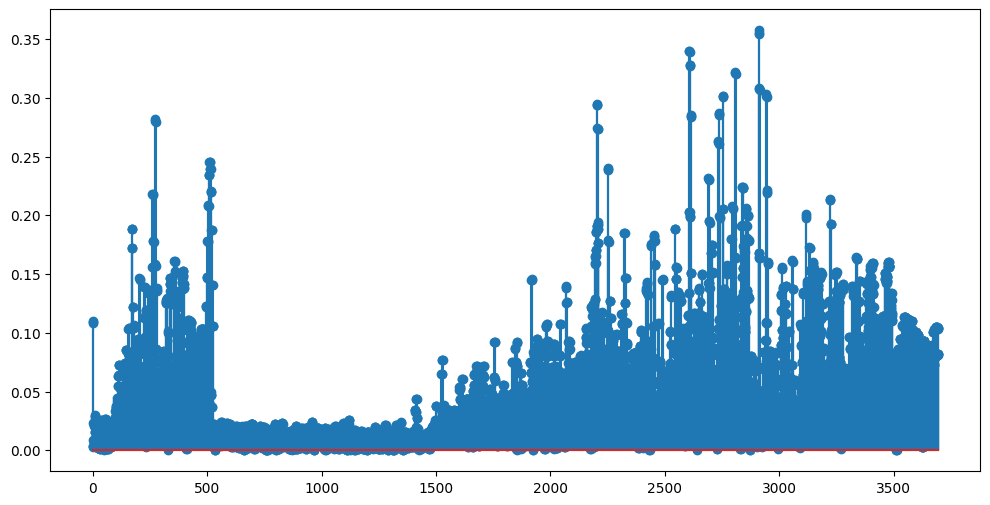

In [15]:
plt.figure(figsize=(12, 6))
plt.stem(np.abs(corr_params_obs).mean(axis=0))
plt.stem(np.abs(corr_params_obs[2, :]))